<a href="https://colab.research.google.com/github/Bayaniblues/DS-Unit-2-Linear-Models/blob/master/Copy_of_LS_DS_212_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 2*

---

# Regression 2

## Assignment

You'll continue to **predict how much it costs to rent an apartment in NYC,** using the dataset from renthop.com.

- [X] Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.
- [X] Engineer at least two new features. (See below for explanation & ideas.)
- [X] Fit a linear regression model with at least two features.
- [X] Get the model's coefficients and intercept.
- [ ] Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data.
- [ ] What's the best test MAE you can get? Share your score and features used with your cohort on Slack!
- [ ] As always, commit your notebook to your fork of the GitHub repo.


#### [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering)

> "Some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used." — Pedro Domingos, ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

> "Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." — Andrew Ng, [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf) 

> Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

#### Feature Ideas
- Does the apartment have a description?
- How long is the description?
- How many total perks does each apartment have?
- Are cats _or_ dogs allowed?
- Are cats _and_ dogs allowed?
- Total number of rooms (beds + baths)
- Ratio of beds to baths
- What's the neighborhood, based on address or latitude & longitude?

## Stretch Goals
- [ ] If you want more math, skim [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf),  Chapter 3.1, Simple Linear Regression, & Chapter 3.2, Multiple Linear Regression
- [ ] If you want more introduction, watch [Brandon Foltz, Statistics 101: Simple Linear Regression](https://www.youtube.com/watch?v=ZkjP5RJLQF4)
(20 minutes, over 1 million views)
- [ ] Add your own stretch goal(s) !

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import numpy as np
import pandas as pd

# Read New York City apartment rental listing data
df = pd.read_csv(DATA_PATH+'apartments/renthop-nyc.csv')
assert df.shape == (49352, 34)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

In [20]:
df

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
0,1.5,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.0,2,2016-06-12 12:19:27,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.0,1,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.0,4,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49347,1.0,2,2016-06-02 05:41:05,"30TH/3RD, MASSIVE CONV 2BR IN LUXURY FULL SERV...",E 30 St,40.7426,-73.9790,3200,230 E 30 St,medium,1,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
49348,1.0,1,2016-04-04 18:22:34,"HIGH END condo finishes, swimming pool, and ki...",Rector Pl,40.7102,-74.0163,3950,225 Rector Place,low,1,1,0,1,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
49349,1.0,1,2016-04-16 02:13:40,Large Renovated One Bedroom Apartment with Sta...,West 45th Street,40.7601,-73.9900,2595,341 West 45th Street,low,1,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
49350,1.0,0,2016-04-08 02:13:33,Stylishly sleek studio apartment with unsurpas...,Wall Street,40.7066,-74.0101,3350,37 Wall Street,low,1,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Train/test Split

In [0]:
df['created'] = pd.to_datetime(df['created'])

In [22]:
mask = (df['created'] > '2016-04-01') & (df['created'] <= '2016-05-01')
train = df.loc[mask]

train.shape

(16217, 34)

In [23]:
# from April & May 2016 to train. Use data from June 2016 to test.
maskt = (df['created'] > '2016-06-01')
test = df.loc[maskt]
train.shape, test.shape

((16217, 34), (16973, 34))

In [24]:
train['bedrooms'].mean()

1.5150767712893878

In [0]:
target  = 'bedrooms'
y_train = train[target]
y_test  = test[target]

In [26]:
y_train

2        1
3        1
4        4
5        4
6        2
        ..
49346    1
49348    1
49349    1
49350    0
49351    2
Name: bedrooms, Length: 16217, dtype: int64

In [27]:
y_test

0        3
1        2
11       1
14       1
24       4
        ..
49305    2
49310    3
49320    1
49332    2
49347    2
Name: bedrooms, Length: 16973, dtype: int64

In [28]:
guess = y_train.mean()
guess

1.5150767712893878

In [29]:
def test_error(X, header):
  from sklearn.metrics import mean_absolute_error
  y_pred = [guess] * len(X)
  mae    = mean_absolute_error(X, y_pred)
  return print(f'{header} is {mae:.2f}')

test_error(y_train, "Train error")

test_error(y_test, "Test error")
# THe train and test are the same that makes me feel like this is inaccurate

Train error is 0.93
Test error is 0.93


## Used the function from the previous lesson to build features

In [30]:


# Built a function to pass arbitrary values, X, Y and input value
def sk_predict(df, X, Y, in_value):
  from sklearn.linear_model import LinearRegression

  # Linear Regression
  model = LinearRegression()

  # features and target take string perimetersd
  features = [X]
  target   = [Y]
  x_Train  = df[features]
  y_Train  = df[target]

  # This fits the model
  model.fit(x_Train, y_Train)

  print("The model coefficient adds $", model.coef_[0], "for every ", X)

  # Input value
  input_value = in_value
  x_test = [[input_value]]
  y_pred = model.predict(x_test)

  # return our desired prediction
  return y_pred

def plotly(x1,y1,x2,y2):
  import plotly.graph_objects as go

  fig = go.Figure()

  # Add traces
  fig.add_trace(go.Scatter(x=x1, y=y1,
                      mode='markers',
                      name='Ground Truth'))

  fig.add_trace(go.Scatter(x=x2, y=y2,
                      mode='lines+markers',
                      name='Prediction'))

  return fig.show()


# chart prediction calls nested sk_predict function and plotly function
def chart_prediction(df, X, Y, range1, range2):
  stored_data = []
  x2 = []
  for i in range(range1,range2):
    stored_data.append(sk_predict(df,X, Y, i))
    x2.append(i)

  pretty_data = []
  # prettify array
  for i in range(range1,range2):
    pretty_data.append(stored_data[i][0][0])

  X = df[X]
  Y = df[Y]

  return plotly(X,Y,x2, pretty_data)


chart_prediction(df, 'loft','price', 0, 9)



The model coefficient adds $ [61.88323872] for every  loft
The model coefficient adds $ [61.88323872] for every  loft
The model coefficient adds $ [61.88323872] for every  loft
The model coefficient adds $ [61.88323872] for every  loft
The model coefficient adds $ [61.88323872] for every  loft
The model coefficient adds $ [61.88323872] for every  loft
The model coefficient adds $ [61.88323872] for every  loft
The model coefficient adds $ [61.88323872] for every  loft
The model coefficient adds $ [61.88323872] for every  loft


61 dollers is added for each theoretical loft

## multiple regression

In [0]:
import itertools
import numpy as np
import plotly.express as px
import plotly.graph_objs as go
from sklearn.linear_model import LinearRegression

def regression_3d(df, x, y, z, num=100, **kwargs):
    """
    Visualize linear regression in 3D: 2 features + 1 target
    
    df : Pandas DataFrame
    x : string, feature 1 column in df
    y : string, feature 2 column in df
    z : string, target column in df
    num : integer, number of quantiles for each feature
    """
    
    # Plot data
    fig = px.scatter_3d(df, x, y, z, **kwargs)
    
    # Fit Linear Regression
    features = [x, y]
    target = z
    model = LinearRegression()
    model.fit(df[features], df[target])
    print(model.coef_)    
    
    # Define grid of coordinates in the feature space
    xmin, xmax = df[x].min(), df[x].max()
    ymin, ymax = df[y].min(), df[y].max()
    xcoords = np.linspace(xmin, xmax, num)
    ycoords = np.linspace(ymin, ymax, num)
    coords = list(itertools.product(xcoords, ycoords))
    
    # Make predictions for the grid
    predictions = model.predict(coords)
    Z = predictions.reshape(num, num).T
    
    # Plot predictions as a 3D surface (plane)
    fig.add_trace(go.Surface(x=xcoords, y=ycoords, z=Z))
    
    return fig

In [44]:
train.columns.tolist()

['bathrooms',
 'bedrooms',
 'created',
 'description',
 'display_address',
 'latitude',
 'longitude',
 'price',
 'street_address',
 'interest_level',
 'elevator',
 'cats_allowed',
 'hardwood_floors',
 'dogs_allowed',
 'doorman',
 'dishwasher',
 'no_fee',
 'laundry_in_building',
 'fitness_center',
 'pre-war',
 'laundry_in_unit',
 'roof_deck',
 'outdoor_space',
 'dining_room',
 'high_speed_internet',
 'balcony',
 'swimming_pool',
 'new_construction',
 'terrace',
 'exclusive',
 'loft',
 'garden_patio',
 'wheelchair_access',
 'common_outdoor_space']

In [45]:
df2 = df.replace(['low', 'medium', 'high'], [1,2,3])
df2

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
0,1.5,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.0,2,2016-06-12 12:19:27,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,1,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,3,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.0,1,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.0,4,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49347,1.0,2,2016-06-02 05:41:05,"30TH/3RD, MASSIVE CONV 2BR IN LUXURY FULL SERV...",E 30 St,40.7426,-73.9790,3200,230 E 30 St,2,1,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
49348,1.0,1,2016-04-04 18:22:34,"HIGH END condo finishes, swimming pool, and ki...",Rector Pl,40.7102,-74.0163,3950,225 Rector Place,1,1,1,0,1,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
49349,1.0,1,2016-04-16 02:13:40,Large Renovated One Bedroom Apartment with Sta...,West 45th Street,40.7601,-73.9900,2595,341 West 45th Street,1,1,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
49350,1.0,0,2016-04-08 02:13:33,Stylishly sleek studio apartment with unsurpas...,Wall Street,40.7066,-74.0101,3350,37 Wall Street,1,1,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
x = 'interest_level'
y = 'bedrooms'
z = 'price'
text = 'price'
title = "How interest level and bedrooms relates to price"

In [47]:
regression_3d(df2, 
              x=x, 
              y=y, 
              z=z, 
              #text, 
              title=title)

[-639.7952344   867.92119552]


In the above image, We see how the gradient shows the relationship between price and the number of bedrooms. The more bedrooms an apartment has the more expensive it is, which is a given. 

We can also make a conjecture that the more expensive apartments are, the less desireable it is. The most desireable type of apartment is probably a four bedroom, within the price range of 1503, and 8000. 

-----------

The coefficient is about -640 for each interest_level, and 868 for each bedroom.

## Find MAE

- [ ] Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data.
- [ ] What's the best test MAE you can get? Share your score and features used with your cohort on Slack!

In [52]:
df2

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
0,1.5,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.0,2,2016-06-12 12:19:27,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,1,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,3,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.0,1,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.0,4,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49347,1.0,2,2016-06-02 05:41:05,"30TH/3RD, MASSIVE CONV 2BR IN LUXURY FULL SERV...",E 30 St,40.7426,-73.9790,3200,230 E 30 St,2,1,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
49348,1.0,1,2016-04-04 18:22:34,"HIGH END condo finishes, swimming pool, and ki...",Rector Pl,40.7102,-74.0163,3950,225 Rector Place,1,1,1,0,1,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
49349,1.0,1,2016-04-16 02:13:40,Large Renovated One Bedroom Apartment with Sta...,West 45th Street,40.7601,-73.9900,2595,341 West 45th Street,1,1,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
49350,1.0,0,2016-04-08 02:13:33,Stylishly sleek studio apartment with unsurpas...,Wall Street,40.7066,-74.0101,3350,37 Wall Street,1,1,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def squared_errors(df, feat, target, m, b):
    # Plot data
    fig = plt.figure(figsize=(7,7))
    ax = plt.axes()
    df.plot.scatter(feature, target, ax=ax)
    
    # Make predictions
    x = df[feature]
    y = df[target]
    y_pred = m*x + b
    
    # Plot predictions
    ax.plot(x, y_pred)
    
    # Plot squared errors
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    scale = (xmax-xmin)/(ymax-ymin)
    for x, y1, y2 in zip(x, y, y_pred):
        bottom_left = (x, min(y1, y2))
        height = abs(y1 - y2)
        width = height * scale
        ax.add_patch(Rectangle(xy=bottom_left, width=width, height=height, alpha=0.1))
    
    # Print regression metrics
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    print('Mean Squared Error:', mse)
    print('Root Mean Squared Error:', rmse)
    print('Mean Absolute Error:', mae)
    print('R^2:', r2)

Mean Squared Error: 15546731.54747153
Root Mean Squared Error: 3942.934382851372
Mean Absolute Error: 3544.4851082197683
R^2: -4.211153827906395


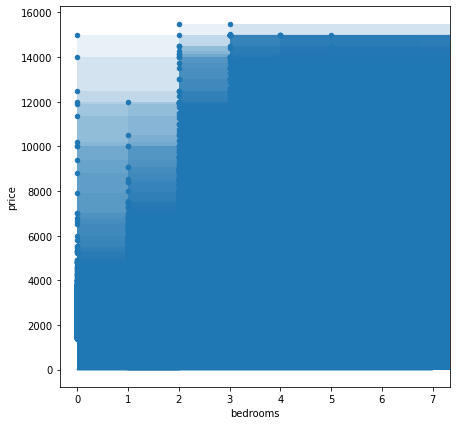

In [55]:
feature = 'bedrooms'
target  = 'price'
squared_errors(train, feature, target, m=0, b=y_train.mean())

# Is this the typical way to find the MAE? I just followed the lecture example

### Questions



1.   I found the coefficient but what does intercept mean? Does it relate to football? Did I intercept without realizing it?
2.   How do I know if my visualizations will communicate well? Does that require A/B testing?

I think the hardest part of this course so far is accepting new jargon, and communicating my over engineered exploritory visualizations. I acknowledge that I overengineer things sometimes, but I think it is essential for me to explore the data in this way so I can fully understand what I'm working with. I think I just need to make sure my descriptive analysis communicate well, but I think that requires A/B testing. 